<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-mutations" data-toc-modified-id="Load-mutations-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load mutations</a></span></li><li><span><a href="#iModulon-Activities" data-toc-modified-id="iModulon-Activities-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>iModulon Activities</a></span></li><li><span><a href="#MarR" data-toc-modified-id="MarR-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>MarR</a></span></li><li><span><a href="#RcsAB" data-toc-modified-id="RcsAB-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>RcsAB</a></span></li><li><span><a href="#SoxS" data-toc-modified-id="SoxS-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>SoxS</a></span></li></ul></div>

In [1]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import os
from itertools import combinations
import seaborn as sns
from scipy import stats

In [2]:
sns.set_style('ticks')

In [3]:
# Use custom stylesheet for figures
plt.style.use('custom')

In [4]:
DATA_DIR = '../../data'
GENE_DIR = os.path.join(DATA_DIR,'annotation/')

In [5]:
gene_info = pd.read_csv(os.path.join(GENE_DIR,'gene_info.csv'),index_col=0)
trn = pd.read_csv(os.path.join(GENE_DIR,'TRN.csv'),index_col=0)

In [6]:
cutoffs = {'RNAseq-2': 300}
datasets = ['RNAseq-2']

In [7]:
class IcaData():
    def __init__(self,M,A,X,metadata,cutoff):
        self.M = pd.read_csv(M,index_col=0)
        self.M.columns = self.M.columns.astype(int)
        self.A = pd.read_csv(A,index_col=0)
        self.A.index = self.A.index.astype(int)
        self.X = pd.read_csv(X,index_col=0)
        self.metadata = pd.read_csv(metadata,index_col=0)
        self.thresholds = {k:self.get_threshold(k,cutoff) for k in self.M.columns}
    
    def show_enriched(self,k):
        gene_table = gene_info.copy()
        gene_table = gene_table.reindex(self.M.index)
        in_imod = abs(self.M[k]) > self.thresholds[k]
        weights = self.M.loc[in_imod,k]
        weights.name = 'weight'
        rows = gene_table.loc[in_imod]
        final_rows = pd.concat([weights,rows],axis=1)
        return final_rows
    
    def get_threshold(self,k,cutoff):
        i=0
        genes = abs(self.M[k]).sort_values()
        k2,p = stats.normaltest(self.M[k])
        while k2 > cutoff:
            i -= 1
            k2,p = stats.normaltest(self.M.loc[genes.index[:i],k])
        imod_genes = genes.iloc[i:]
        return np.mean([genes.iloc[i], genes.iloc[i - 1]])

def load(dataset):
    # Define directories
    ds_dir = os.path.join(DATA_DIR,'iModulons',dataset)
    X_file = os.path.join(DATA_DIR,'processed_data',dataset+'.csv')
    metadata_file = os.path.join(DATA_DIR,'metadata',dataset+'_metadata.csv')
    
    M_file = os.path.join(ds_dir,'M.csv')
    A_file = os.path.join(ds_dir,'A.csv')
    
    return IcaData(M_file,A_file,X_file,metadata_file,cutoffs[dataset])

In [8]:
ica_data = load('RNAseq-2')

In [9]:
DF_categories=pd.read_csv(os.path.join(DATA_DIR,'iModulons','categories_curated.csv'),index_col=0)
DF_categories = DF_categories[DF_categories.dataset=='RNAseq-2']
DF_categories = DF_categories.set_index('component',drop=True)

In [10]:
DF_categories.head()

,dataset,curated,type,description,pvalue,qvalue,precision,recall,f1score,TP,LFC
component,,,,,,,,,,,
0,RNAseq-2,NaN,regulatory,crp,4.072013e-15,1.119804e-12,0.480519,0.078723,0.135283,37.0,NaN
1,RNAseq-2,NaN,regulatory,arcA,7.101213e-09,1.952834e-06,0.280000,0.086420,0.132075,14.0,NaN
2,RNAseq-2,NaN,regulatory,rob,5.919553e-19,1.627877e-16,0.232143,0.541667,0.325000,13.0,NaN
3,RNAseq-2,NaN,regulatory,nikR,4.924379e-15,1.186775e-12,0.833333,0.833333,0.833333,5.0,NaN
4,RNAseq-2,NaN,uncharacterized,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Load mutations

In [14]:
mut_file = os.path.join(DATA_DIR,'metadata','Data_S3_from_lazar_2014.xls')

In [15]:
snvs = pd.read_excel(mut_file,sheet_name='pointMutations',skiprows=2)

ins = pd.read_excel(mut_file,sheet_name='insertions',skiprows=2)

dels1 = pd.read_excel(mut_file,sheet_name='smallDeletions',skiprows=2)
dels2 = pd.read_excel(mut_file,sheet_name='largeDeletions',skiprows=2)

is_rearrangements = pd.read_excel(mut_file,sheet_name='ISRelatedGenomicRearrangements',skiprows=2)

ins = pd.read_excel(mut_file,sheet_name='insertions',skiprows=2)

In [16]:
DF_muts = pd.concat([snvs,ins,dels1,dels2,is_rearrangements])

In [17]:
strains = [x[:4].upper() for x in ica_data.A.columns]

In [18]:
DF_muts = DF_muts[DF_muts.Strain.isin(strains)]

# iModulon Activities

In [19]:
abx_metadata = ica_data.metadata
abx_A = ica_data.A

In [20]:
def plot_imodulon(k):
    test = pd.DataFrame()
    for (proj,cond),group in abx_metadata.groupby(['project_id','condition_id']):
        test[proj+'_'+cond] = abx_A.loc[k,group.index].tolist()
    test.columns = [x[:-4] if 'wt' not in x else 'WT' for x in test.columns]

    fig,ax = plt.subplots(figsize=(5,1))
    sns.barplot(data=test.melt(),y='value',x='variable',ax=ax,ci=None)
    sns.stripplot(data=test.melt(),y='value',x='variable',ax=ax,color='k',s=3,jitter=0.1)
    ax.tick_params(axis='x',labelrotation=45)
    if DF_categories.loc[k,'type'] in ['regulatory','biological']:
        title = DF_categories.loc[k,'description'] + ' ('+str(k)+')'
    else:
        title = DF_categories.loc[k,'type'] + '('+str(k)+')'
    ax.set_title(title)
    return test.melt()

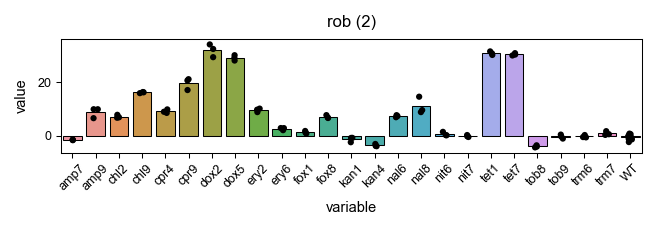

In [21]:
vals = plot_imodulon(2)

# MarR

In [22]:
marR_muts = pd.DataFrame(columns = sorted(ica_data.metadata.project_id.str.upper().unique()))

for strain in DF_muts[DF_muts['Overlapping annotations'] == 'marR'].Strain:
    marR_muts.loc['marR',strain] = 1
for strain in DF_muts[DF_muts['Overlapping annotations'] == 'rob'].Strain:
    marR_muts.loc['rob',strain] = 1
for strain in DF_muts[(DF_muts['Overlapping annotations'] == 'acrR')].Strain:
    marR_muts.loc['acrR',strain] = 1
    
for strain in DF_muts[DF_muts['interrupted gene'] == 'acrR'].Strain:
    marR_muts.loc['acrR',strain] = 1
    
marR_muts = marR_muts.fillna(0)

In [23]:
marR_vals = vals.groupby('variable').mean().T
marR_vals.columns = marR_vals.columns.str.upper()
marR_vals = marR_vals[marR_muts.columns]

<AxesSubplot:>

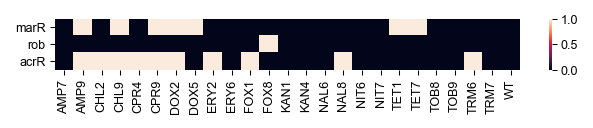

In [24]:
fig,ax = plt.subplots(figsize=(5,0.45))
sns.heatmap(marR_muts)

# RcsAB

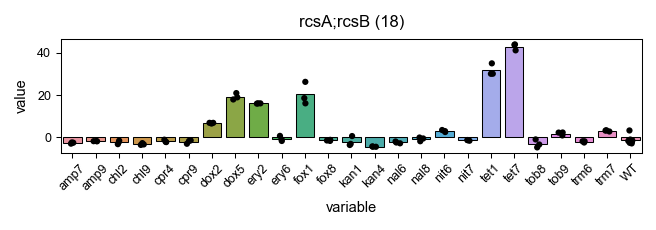

In [25]:
plot_imodulon(18);

In [26]:
lon_muts = pd.DataFrame(columns = sorted(ica_data.metadata.project_id.str.upper().unique()))

for strain in DF_muts[DF_muts.Region.notnull() & DF_muts.Region.str.startswith('458024')].Strain:
    lon_muts.loc['inversion',strain] = 1
    
lon_muts = lon_muts.fillna(0)

<AxesSubplot:>

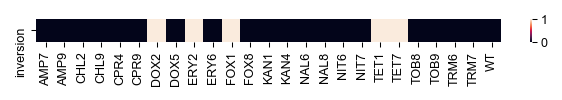

In [27]:
fig,ax = plt.subplots(figsize=(5,0.2))
sns.heatmap(lon_muts)

# SoxS

In [28]:
DF_muts[DF_muts['Overlapping annotations'] == 'soxR']

,Strain,Drug evolved to,Reference Position,Type,Reference,Allele,Overlapping annotations,Coding region change,Amino acid change,Compromised function,Length,Start bp,Stop bp,Region,Evidence,IS,insertion sequence,interrupted gene
72,ERY2,ERY,4275902.0,SNV,C,G,soxR,411C>G,Asp137Glu,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
161,TRM6,TRM,4275826.0,SNV,T,A,soxR,335T>A,Leu112Gln,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163,NAL6,NAL,4275907.0,SNV,T,G,soxR,416T>G,Leu139*,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,CPR4,CPR,NaN,Deletion,NaN,NaN,soxR,378_380delGCG,Ser126_Arg127delinsSer,no,3.0,4275869.0,4275871.0,NaN,NaN,NaN,NaN,NaN


In [29]:
soxS_regulon = set(trn[trn.TF == 'soxS'].gene_id.values)
rob_regulon = set(trn[trn.TF == 'rob'].gene_id.values)
marA_regulon = set(trn[trn.TF == 'marA'].gene_id.values)

In [30]:
from matplotlib_venn import venn3,venn2

0.5526315789473685
0.875
0.5


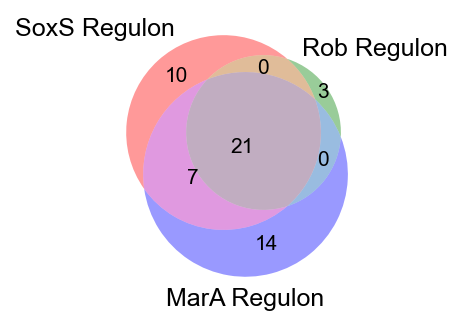

In [31]:
venn3((soxS_regulon,rob_regulon,marA_regulon),set_labels=['SoxS Regulon','Rob Regulon','MarA Regulon'])
print(21/len(soxS_regulon))
print(21/len(rob_regulon))
print(21/len(marA_regulon))

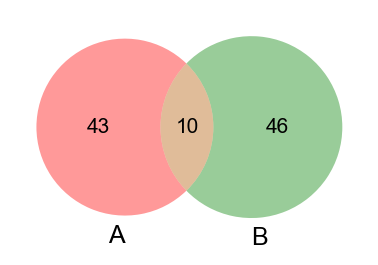

In [32]:
venn2((set(ica_data.show_enriched(27).index),set(ica_data.show_enriched(2).index)))

,variable,value
0,amp7,-3.027580
1,amp7,-3.127693
2,amp7,-3.179790
3,amp9,0.207286
4,amp9,-0.649945
...,...,...
79,WT,-2.802435
80,WT,-3.562753
81,WT,-1.437071
82,WT,1.654338


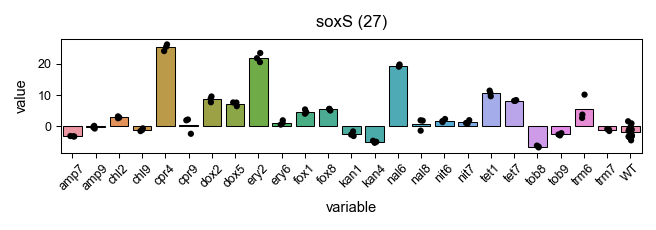

In [33]:
plot_imodulon(27)

In [34]:
sox_muts = pd.DataFrame(columns = sorted(ica_data.metadata.project_id.str.upper().unique()))

for strain in DF_muts[DF_muts['Overlapping annotations'] == 'soxR'].Strain:
    sox_muts.loc['inversion',strain] = 1
    
sox_muts = sox_muts.fillna(0)

<AxesSubplot:>

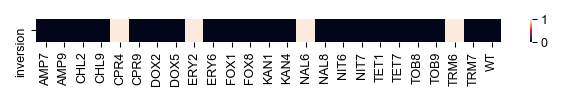

In [35]:
fig,ax = plt.subplots(figsize=(5,0.2))
sns.heatmap(sox_muts)